# Emotional Speech Recognition
This notebook will be an audio classification problem and solved with Audio Feature extraction and augmentation, Machine Learning and Deep Learning. 

https://www.kaggle.com/dejolilandry/asvpesdspeech-nonspeech-emotional-utterances

In [95]:
import numpy as np 
import pandas as pd
import os 
import math
import torch 
import torchaudio 
from torch.utils.data import Dataset, dataloader
import matplotlib.pyplot as plt 
#%matplotlib_inline
import seaborn as sns
import librosa 
import librosa.display

import IPython.display as ipd

# Data Preperation 
Since the dataset didnt come with a CSV file containing the metadata we'll create a dataframe that contains the Path to the Wav file and it Class which is what emotion it has been labeled as. 

Taken from the Kaggle Dataset Descri

Each wav file in the dataset consists of numerical identifiers. 

Filename identifiers:
Modality ( 03 = audio-only).
Vocal channel on s(01 = speech, 02 = npeech).
Emotion ( 01 = boredom, 02 = neutral, 03 = happy, 04 = sad, 05 = angry, 06 = fearful, 07 = disgust, 08 = surprised, 09 = excited, 10 = pleasure, 11 = pain, 12 = disappointment, 13 = others).
Emotional intensity (01 = normal, 02 = high).
Statement (as it’s non scripted this refer to the number of sample select per actor folder ).
Actor ( even numbered acteurs are male, odd numbered actors are female).
Age(01 = above 65, 02 = between 20~64, 03 = under 20,04=new born).
Source of downloading (01 =website , 02 = youtube channel, 03= movies).
Language(01=Chinese , 02=English ,04 = french , others).



In [96]:
labels_dict = {
    1: 'boredom', 
    2: 'neutral',
    3: 'happy',
    4: 'sad',
    5: 'angry',
    6: 'fearful',
    7: 'disgust', 
    8: 'surprised',
    9: 'excited', 
    10: 'pleasure',
    11: 'pain', 
    12: 'disappointment', 
    13: 'others'
}

So by taking a look at how the data is labeled we can decide how to make classification for our problem. Lets start simple and just use the Emotion label. Later we can try classifying other labels like age and gender. We'll also only use files labeled as speech, later we'll use the non speech files for data augmentation but more on that later. for now lets make a list 

In [97]:
# lets practice taking the path strings apart 
ster = "/Users/stephen/Desktop/Speech_Commands/Data/ASVP-ESD_UPDATE/Audio/actor_103/03-01-05-01-07-103-02-01-02-18.wav"
part = ster.split('/')[-1]
part = part.split('.')[0]
part = part.split('-')
print(part)

['03', '01', '05', '01', '07', '103', '02', '01', '02', '18']


In [98]:
# string representing PATH for folder containing data
audio_path = '/Users/stephen/Desktop/Speech_Commands/Data/ASVP-ESD_UPDATE/Audio/'

# the dataset is organized into folders for each actor/actress. the listdir method will list all contained folders 
dir_list = os.listdir(audio_path)


file_emotion = []
file_path = []
file_fold = []

# iterate through files and 
for dir in dir_list:
    # extract contents from each folder 
    actor = os.listdir(audio_path + dir)
    # go through each file in each folder 
    for file in actor: 
        part = file.split('.')[0] # ignore the .wav
        part = part.split('-')
        # the second part represents speech or non speech 
        if part[1] == '01': # 01 represents Speech 
            # third part represents emotion 
            file_emotion.append(int(part[2]))
            file_path.append('/' + file)
            file_fold.append(dir)



# dataframe for emotion of files 
emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])

# dataframe for path of files 
path_df = pd.DataFrame(file_path, columns=['Path'])

# dataframe for names of folders 
fold_df = pd.DataFrame(file_fold, columns=['Folder'])

metadata = pd.concat([emotion_df, path_df, fold_df], axis=1)

# change integers to actual emotions. 
metadata.Emotions.replace(labels_dict, inplace=True)
metadata.head()

,Emotions,Path,Folder
0,neutral,/03-01-02-01-02-16-03-03-01.wav,actor_16
1,angry,/03-01-05-02-07-16-03-03-01.wav,actor_16
2,neutral,/03-01-02-01-13-16-03-03-01.wav,actor_16
3,neutral,/03-01-02-01-05-16-03-03-01.wav,actor_16
4,angry,/03-01-05-02-06-16-03-03-01.wav,actor_16


In [99]:
# Sanity check to make sure the Path Column contains the fill path 
metadata['Path'][0]

'/03-01-02-01-02-16-03-03-01.wav'

In [107]:
# lets save to CSV file for later use. The PandasData frame will be used to visualize some data 
metadata.to_csv('/Users/stephen/Desktop/Speech_Commands/Data/ASVP-ESD_UPDATE/metadata.csv', index=False)

# Data Visualization 
lets makes some visuals 



In [101]:
metadata['Emotions'].value_counts()

neutral           1019
angry              987
happy              495
sad                471
surprised          327
disappointment     241
fearful            137
disgust             93
excited             92
pain                36
boredom             26
pleasure            22
Name: Emotions, dtype: int64

/Users/stephen/opt/anaconda3/envs/torch_env/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


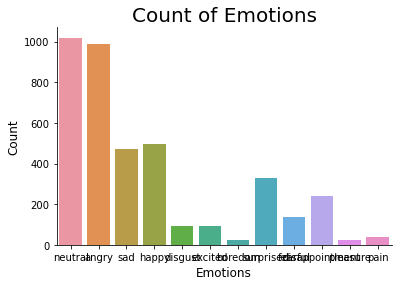

In [102]:
plt.title('Count of Emotions', size=20)
sns.countplot(metadata.Emotions)
plt.ylabel('Count', size=12)
plt.xlabel('Emotions', size=12)
sns.despine(top=True, right=True, left=False, bottom=False)
plt.show()

In [125]:
audio_path

'/Users/stephen/Desktop/Speech_Commands/Data/ASVP-ESD_UPDATE/Audio/'

In [140]:
d = pd.read_csv('/Users/stephen/Desktop/Speech_Commands/Data/ASVP-ESD_UPDATE/metadata.csv')
d.iloc[0, 2]

'actor_16'

# Data Preprossing 

not that we are able to locate our data properly we'll create a custom Dataset object with Pytorch. This will make it easier to work with 

In [141]:
# Pytorch Dataset class 

class EmotionalSpeechDataset(Dataset):
    # constructor 
    def __init__(self, annotations_file, audio_dir, target_sample_rate, num_samples, device, transformation=None): 
        self.annotations_file = pd.read_csv(annotations_file)
        self.audio_dir = audio_dir 
        self.target_sample_rate = target_sample_rate
        self.num_samples = num_samples 
        self.device = device 
        self.transformation = transformation

    def __len__(self):
        return len(self.annotations_file)

    def __getitem__(self, index):
        audio_sample_path = self._get_audio_sample_path(index)
        label = self._get_audio_sample_label(index)
        signal, sr = torchaudio.load(audio_sample_path)
        signal = signal.to(self.device)
        signal = self._resample_if_necessary(signal, sr)
        signal = self._mix_down_if_necessary(signal)
        signal = self._cut_if_necessary(signal)
        signal = self._right_pad_if_necessary(signal)

        # if a transformation is stated, apply to audio tensor 
        if self.transformation: 
            signal = self.transformation(signal).to(self.device)
        return signal, label 

    def _cut_if_necessary(self, signal):
        if signal.shape[1] > self.num_samples:
            signal = signal[:, :self.num_samples]
        return signal 

    def _right_pad_if_necessary(self, signal): 
        length_signal = signal.shape[1]
        if length_signal < self.num_samples:    # compare each file with desired length 
            num_missing_samples = self.num_samples - length_signal 
            last_dim_padding = (0, num_missing_samples)
            signal = torch.nn.functional.pad(signal, last_dim_padding)
        return signal 

    def _resample_if_necessary(self, signal):
        if sr != self.target_sample_rate:
            resampler = torchaudio.transforms.Resample(sr, self.target_sample_rate)
            signal = resampler(signal)
        return signal 

    def _mix_down_if_necessary(self, signal):  # if file is Stereo, convert to mono by using the mean 
        if signal.shape[0] > 1:
            signal = torch.mean(signal, dim=0, keepdim=True)
        return signal 

    def _get_audio_path(self, index):
        fold = f"fold{self.annotations.iloc[index, 2]}"    # grab from "Folder" column 
        path = os.path.join(self.audio_dir, fold, self.annotations_file.iloc[index, 1]) # combine to make full PATH
        return path 
    
    def _get_audio_sample_label(self, index):
        return self.annotations.iloc[index, 0]  # grab from "label" column  



        

In [142]:
if torch.cuda.is_available():
    device="cuda"
else:
    device="cpu"



emotional_speech_dataset = EmotionalSpeechDataset(
    annotations_file='/Users/stephen/Desktop/Speech_Commands/Data/ASVP-ESD_UPDATE/metadata.csv/',
    audio_dir=audio_path,
    target_sample_rate=16000,
    num_samples=16000*20, 
    device=device)

NotADirectoryError: [Errno 20] Not a directory: '/Users/stephen/Desktop/Speech_Commands/Data/ASVP-ESD_UPDATE/metadata.csv/'

In [120]:
len(emotional_speech_dataset)

3946

In [118]:
emotional_speech_dataset[0]

AttributeError: 